<a href="https://colab.research.google.com/github/Harsh-58/DataScienceA2/blob/main/HarsJainU5proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm

from scipy.interpolate import PchipInterpolator

# Penguin Body Mass vs. Flipper Length GLM


**Why**: I chose to explore the relationship between penguin flipper length and body mass because it’s fascinating to see how physical traits like these might be connected. A larger body mass could mean longer flippers, which might help with swimming or adapting to their environment. Looking at these patterns gives us a better understanding of penguin biology and how their bodies are built for survival. Therefore, instead of focusing on one species I'm going to be analyzing penguins in general. Plus, I think penguins are adorable, so studying them makes this project even more fun.

In [ ]:
#load the data into a pandas dataframe, and print it
url_penguin = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv'
penguin = pd.read_csv(url_penguin)

In [ ]:
penguin

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
340,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
341,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
342,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


<Axes: xlabel='flipper_length', ylabel='body_mass'>

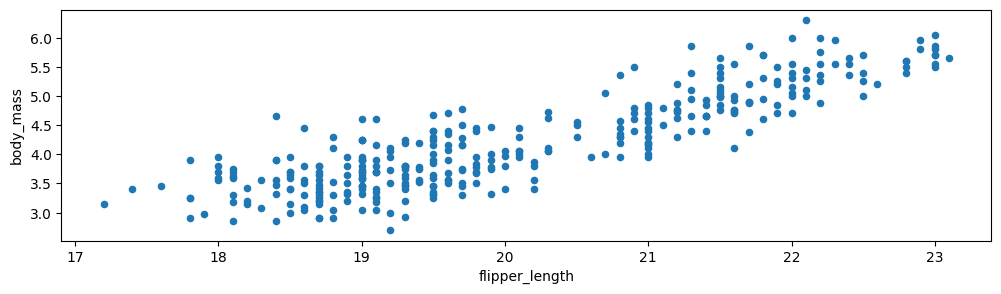

In [ ]:
penguin.plot(x="flipper_length", y="body_mass", figsize=(12, 3), kind="scatter")

I created a scatter plot to visualize the relationship between flipper length and body mass, helping to identify any patterns or trends in the data. I can clearly see a positive linear trend with this plot.


<Axes: >

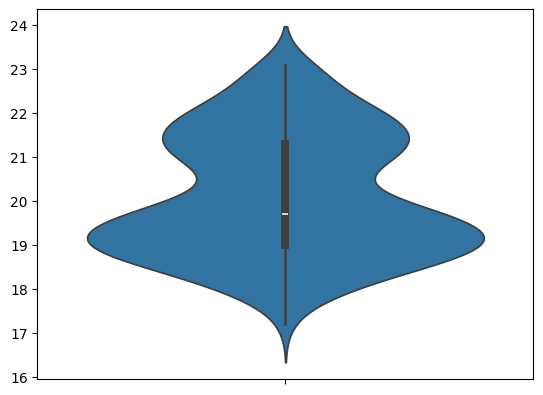

In [ ]:
sns.violinplot(x)


I made a violin plot for the flipper length variable to better understand its distribution and spread. It combines aspects of a box plot and a density plot, allowing me to see both the central tendency and the variability in the data.The violin plot is notably wide at a flipper length of 19, indicating that there is a high density of penguins with flipper lengths around this value.

In [ ]:
# Clean and convert data to NumPy arrays
x = penguin["flipper_length"].dropna().values  # Predictor (x-axis)
y = penguin["body_mass"].dropna().values      # Response (y-axis)

# Ensure both x and y are of the same length
if len(x) != len(y):
    raise ValueError("Mismatched lengths: flipper_length and body_mass must have the same number of observations.")

# PyMC model
with pm.Model() as model_penguin:

    # Priors for the linear model parameters
    α = pm.Normal("α", mu=0, sigma=100)  # Intercept
    β = pm.Normal("β", mu=0, sigma=10)   # Slope

    # Linear model for the mean
    μ = pm.Deterministic("μ", α + β * x)

    # Prior for the standard deviation
    σ = pm.HalfCauchy("σ", beta=10)

    # Likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=y)

    # Inference: Sample from the posterior
    idata_penguin = pm.sample()  # Sampling posterior

Output()

Output()

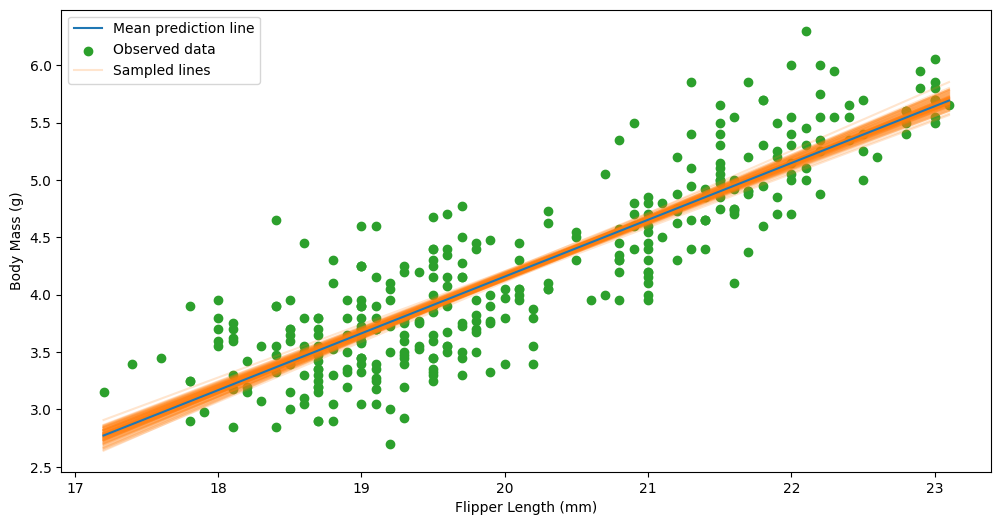

In [ ]:
# Extract posterior samples for visualization
posterior = az.extract(idata_penguin, num_samples=100)

# Create x values for the prediction line
x_plot = xr.DataArray(
    np.linspace(x.min(), x.max(), 50),
    dims="plot_id"
)

# Compute the mean prediction line
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

# Compute 50 sampled lines from the posterior
lines = posterior["α"] + posterior["β"] * x_plot

# Set up the plot
_, ax = plt.subplots(figsize=(12, 6))

# Plot sampled lines without adding them all to the legend
ax.plot(x_plot, lines.T, c="C1", alpha=0.2)  # No label here to avoid clutter

# Plot the mean prediction line
ax.plot(x_plot, mean_line, c="C0", label="Mean prediction line")

# Plot the raw data
ax.scatter(x, y, c="C2", zorder=-3, label="Observed data")

# Add a legend entry for sampled lines manually
ax.plot([], [], c="C1", alpha=0.2, label="Sampled lines")

# Label axes and create legend
ax.set_xlabel("Flipper Length (mm)")
ax.set_ylabel("Body Mass (g)")
ax.legend()
plt.show()

This plot shows the relationship between penguin flipper length and body mass, with the raw data points represented as scattered dots. The mean prediction line, based on the posterior distribution, provides an estimate of the expected body mass for each flipper length. The sampled lines from the posterior represent the variability in the model's predictions, demonstrating the uncertainty around the mean estimate. The points are very spread out since I'm not focusing on one specific species of penguins.

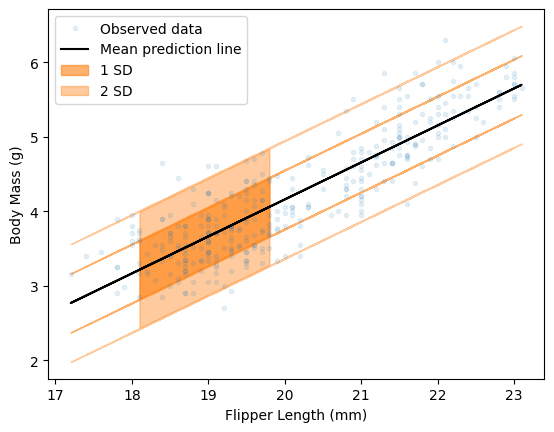

In [ ]:
# Create a figure and axis for plotting
_, ax = plt.subplots()

# Plot raw data: flipper length vs body mass with semi-transparent points
ax.plot(x, y, "C0.", alpha=0.1, label="Observed data")

# Extract posterior samples from the inference data object
posterior_penguin = az.extract(idata_penguin)

# Compute the mean values for μ (mean body mass) and σ (standard deviation) across samples
μ_m = posterior_penguin["μ"].mean("sample").values
σ_m = posterior_penguin["σ"].mean("sample").values

# Plot the mean trend line (μ_m) for body mass as a function of flipper length
ax.plot(x, μ_m, c="k", label="Mean prediction line")

# Add a shaded region representing one standard deviation above and below the mean
ax.fill_between(x, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C1", label="1 SD")

# Add a lighter shaded region representing two standard deviations above and below the mean
ax.fill_between(x, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C1", label="2 SD")

# Label axes and add legend
ax.set_xlabel("Flipper Length (mm)")
ax.set_ylabel("Body Mass (g)")
ax.legend()
plt.show()

The spread of points is clearly shown hear as there are points 2 standard deviation from the mean. I'm fine with this since I want to see the general trend for penguins.

In [ ]:
pm.sample_posterior_predictive(
    idata_penguin, model=model_penguin, extend_inferencedata=True
)


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

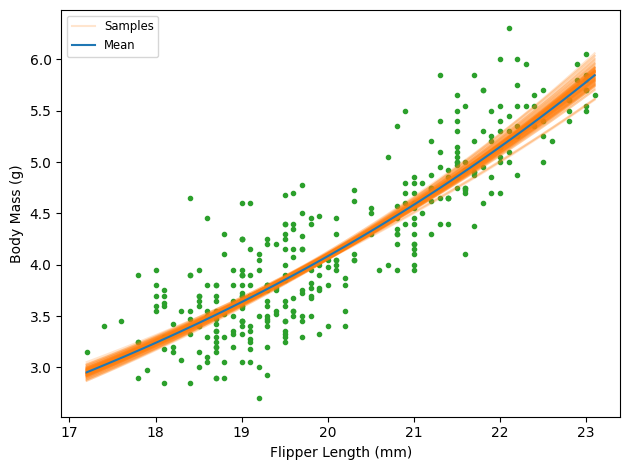

In [ ]:
# Extract 100 posterior samples
posterior = az.extract(idata_penguin_exp, num_samples=100)

# Generate x values for graphing
x_plot = xr.DataArray(
    np.linspace(x.min(), x.max(), 50),
    dims="plot_id"
)

# Compute the mean line
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

# Generate 50 sampled lines
lines = posterior["α"] + posterior["β"] * x_plot

# Set up the plot
_, ax = plt.subplots()

# Plot 50 sampled lines (without adding them all to the legend)
ax.plot(x_plot, np.exp(lines.T), c="C1", alpha=0.2)

# Add a single legend entry for samples
ax.plot([], [], c="C1", alpha=0.2, label="Samples")

# Plot the mean line
ax.plot(x_plot, np.exp(mean_line), c="C0", label="Mean")

# Plot raw data
ax.plot(x, y, "C2.", zorder=-3)

# Label axes
ax.set_xlabel("Flipper Length (mm)")
ax.set_ylabel("Body Mass (g)")

# Add a concise legend
ax.legend(loc="upper left", fontsize="small")

# Adjust layout to avoid cutting off the legend
plt.tight_layout()
plt.show()


This is another graph (with a slightly exponential curve) that shows the relationship between penguin flipper length and body mass, with the raw data points depicted as scattered dots. The mean prediction line (in blue) represents the expected body mass for each flipper length, while the sampled lines (in light red) show the uncertainty in the model's predictions. The plot also illustrates the variability in body mass predictions for different flipper lengths, based on the 100 posterior samples drawn from the model.

In [ ]:
with pm.Model() as model_penguin_exp:

    # Priors for mean line coefficients
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)

    # Define the mean line
    μ = pm.Deterministic("μ", α + β * x)

    # Prior for standard deviation
    σ = pm.HalfNormal("σ", sigma=10)

    # Log-normal likelihood
    y_pred = pm.LogNormal("y_pred", mu=μ, sigma=σ, observed=y)

    # Sample the posterior
    idata_penguin_exp = pm.sample()


Output()

Output()

<Axes: xlabel='y_pred'>

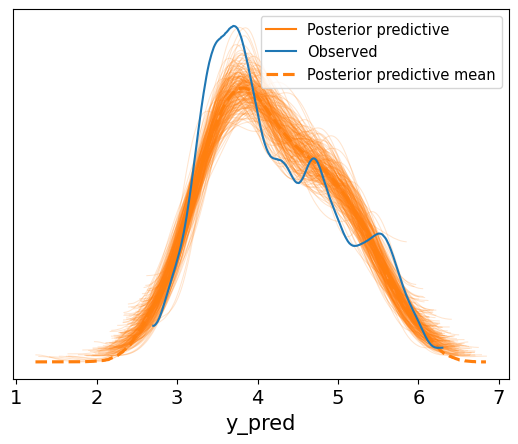

In [ ]:
az.plot_ppc(idata_penguin, num_pp_samples=200, colors=["C1", "C0", "C1"])

This model seems to fit the data well because the mean prediction line closely matches the overall trend in body mass as flipper length increases. The sampled lines also show a realistic range of uncertainty, reflecting the natural variability in the data while still following the general pattern. While the posterior predictive lines could be a little higher I think this fits the data just fine.

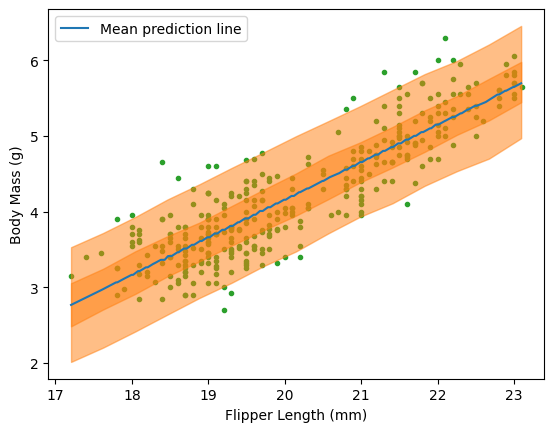

In [ ]:
# Extract the expected line (mean line of best fit)
mean_line = idata_penguin.posterior["μ"].mean(("chain", "draw"))

# Generate x values for prediction
flipper_lengths = np.random.normal(x, 0.01)
idx = np.argsort(flipper_lengths)
x_vals = np.linspace(flipper_lengths.min(), flipper_lengths.max(), 15)

# Compute the 94% and 50% HDI bounds
y_pred_q = idata_penguin.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(flipper_lengths[idx], y_pred_q[i][idx])(x_vals)
        for i in range(4)
    ]
)

# Plot raw data and the line of best fit
_, ax = plt.subplots()
ax.plot(x, y, "C2.", zorder=-3)
ax.plot(flipper_lengths[idx], mean_line[idx], c="C0", label="Mean prediction line")

# Plot 94% and 50% HDI intervals
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x_vals, lb, ub, color="C1", alpha=0.5)

# Label axes and add legend
ax.set_xlabel("Flipper Length (mm)")
ax.set_ylabel("Body Mass (g)")
ax.legend()
plt.show()


**Analysis**: This generalized linear model demonstrates a strong relationship between flipper length and body mass in penguins. The mean prediction line accurately captures the central trend in the data, and the credible intervals (94% and 50% HDI bounds) effectively quantify the uncertainty around the predictions. These intervals show a decent range of variability while still aligning closely with the observed data, indicating that the model is both precise and reliable. I was expecting variability since I didn't focus on one species and if I did I think there would be less variability.



**Conclusion**:This project highlights how flipper length can be a significant predictor of body mass, which is helpful for understanding physical characteristics in penguins and potentially for ecological studies. By modeling this relationship, we gain insights that could guide future research, showing how these models can support biological and environmental understanding.






